In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import sys
import warnings
import tensorflow as tf
from scipy.ndimage.filters import gaussian_filter1d
from sklearn.metrics import mean_squared_error
warnings.filterwarnings('ignore')


# Set the path to the root directory
path = os.path.abspath(os.path.join(os.getcwd(), os.pardir))
sys.path.append(path)


# df1 and df2
df1 = pd.read_csv(path + '/data/predictions/BS_rolling.csv')
display(df1)
df2 = pd.read_csv(path + '/data/predictions/BS_garch.csv')
display(df2)
df1 = df1.rename(columns={"BS": "Rolling"})
df2 = df2.rename(columns={"BS": "GARCH"})
df = df1.merge(df2, on=["Quote_date", "TTM"])
del df2, df1
print("Length of df: ", len(df))
# df3
df3 = pd.read_csv(path + '/data/predictions/BS_IV_surface2.csv')
df3 = df3.rename(columns={"BS": "IV"})
df = df.merge(df3, on=["Quote_date", "TTM"])
del df3
print("Length of df: ", len(df))
# df4
df4 = pd.read_csv(path + '/data/predictions/heston.csv')
df4 = df4.rename(columns={"Heston_price": "Heston"})
df = df.merge(df4, on=["Quote_date", "TTM"])
del df4
print("Length of df: ", len(df))
# df5
df5 = pd.read_csv(path + '/data/predictions/05-07_11-26.csv')
df5 = df5.rename(columns={"Prediction": "Main"})
df = df.merge(df5, on=["Quote_date", "TTM"])
del df5
print("Length of df: ", len(df))

# Print RMSE for all the dataframes
print("RMSE for df1: ", np.sqrt(mean_squared_error(df1["Price"], df1["Rolling"])))
print("RMSE for df2: ", np.sqrt(mean_squared_error(df2["Price"], df2["GARCH"])))
print("RMSE for df3: ", np.sqrt(mean_squared_error(df3["Price"], df3["IV"])))
print("RMSE for df4: ", np.sqrt(mean_squared_error(df4["Price"], df4["Heston"])))
print("RMSE for df5: ", np.sqrt(mean_squared_error(df5["Price"], df5["Main"])))



# Print the length of each dataframe
print("Length of df1: ", len(df1))
print("Length of df2: ", len(df2))
print("Length of df3: ", len(df3))
print("Length of df4: ", len(df4))
print("Length of df5: ", len(df5))

len_df = len(df1)

2023-05-09 11:42:35.853108: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
/var/folders/wk/x86_p6511l95p594k6qnb98h0000gn/T/ipykernel_13928/607090115.py:9: DeprecationWarning: Please use `gaussian_filter1d` from the `scipy.ndimage` namespace, the `scipy.ndimage.filters` namespace is deprecated.
  from scipy.ndimage.filters import gaussian_filter1d


: 

: 

In [ ]:
display(df.sample(10))

In [ ]:
df_read = df.copy()

In [ ]:
df = df_read.copy()

### Params

In [ ]:
base = 150

# RMSE over time

In [ ]:
display(df.sample(10))

,Unnamed: 0_1,Quote_date,Price,Underlying_last_1,Strike,TTM,R,rolling_volatility,Volatility_1,Rolling,...,ttm_bucket,implied_vol_t-1,Volatility,IV,Unnamed: 0_4,Underlying_last_4,Heston,Unnamed: 0_5,Main,Underlying_last_5
19335520,NaN,2020-09-18,0.225,NaN,3750.0,0.000000,0.000900,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,8703138.0,3318.56,-4.475225,NaN,NaN,NaN
23217416,NaN,2017-06-21,100.695,NaN,2345.0,44.000000,0.850000,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3688420.0,97.029015,2435.92
15242826,NaN,2021-12-22,538.350,NaN,4160.0,0.000000,0.000300,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,11171156.0,4696.40,543.262473,NaN,NaN,NaN
18547445,NaN,2020-03-02,70.750,NaN,3085.0,0.000000,0.014100,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,7757414.0,3090.96,62.506216,NaN,NaN,NaN
18729598,NaN,2020-04-14,31.455,NaN,2955.0,0.000000,0.001700,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,7994293.0,2845.92,30.541949,NaN,NaN,NaN
7321964,10006026.0,2021-06-08,1969.150,4227.18,2250.0,0.200000,0.000179,0.120165,0.120165,1977.260371,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
11003531,NaN,2022-04-01,634.100,NaN,4175.0,0.000000,0.016942,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,11768541.0,4545.81,644.292723,NaN,NaN,NaN
8979753,11918172.0,2022-04-29,324.400,4132.17,4030.0,0.383562,0.011715,0.226448,0.226448,292.780923,...,15.0,0.258371,0.258371,324.188715,NaN,NaN,NaN,NaN,NaN,NaN
10165783,13314243.0,2023-01-10,329.750,3919.78,3655.0,0.180822,0.046149,0.202648,0.202648,327.253084,...,11.0,0.219989,0.219989,334.828699,NaN,NaN,NaN,NaN,NaN,NaN
17085126,NaN,2019-01-30,0.850,NaN,2825.0,0.000000,0.024000,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,6178663.0,2681.07,1.318014,NaN,NaN,NaN


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.ticker as ticker
from sklearn.metrics import mean_squared_error

# Define a function to calculate RMSE
def calculate_rmse(group):
    rmse_model_1 = np.sqrt(mean_squared_error(group["Price"], group["Rolling"]))
    rmse_model_2 = np.sqrt(mean_squared_error(group["Price"], group["GARCH"]))
    rmse_model_3 = np.sqrt(mean_squared_error(group["Price"], group["IV"]))
    rmse_model_4 = np.sqrt(mean_squared_error(group["Price"], group["Heston"]))
    rmse_model_5 = np.sqrt(mean_squared_error(group["Price"], group["Main"]))
    return pd.Series({"RMSE_Model_1": rmse_model_1, "RMSE_Model_2": rmse_model_2, "RMSE_Model_3": rmse_model_3, "RMSE_Model_4": rmse_model_4, "RMSE_Model_5": rmse_model_5})

# Group data by Quote_date and calculate RMSE for each group
rmse_df = df.groupby("Quote_date").apply(calculate_rmse).reset_index()


# Smooth the RMSE values by using gaussian filter
sigma = 15
rmse_df["RMSE_Model_1"] = gaussian_filter1d(rmse_df["RMSE_Model_1"], sigma=sigma)
rmse_df["RMSE_Model_2"] = gaussian_filter1d(rmse_df["RMSE_Model_2"], sigma=sigma)
rmse_df["RMSE_Model_3"] = gaussian_filter1d(rmse_df["RMSE_Model_3"], sigma=sigma)
rmse_df["RMSE_Model_4"] = gaussian_filter1d(rmse_df["RMSE_Model_4"], sigma=sigma)
rmse_df["RMSE_Model_5"] = gaussian_filter1d(rmse_df["RMSE_Model_5"], sigma=sigma)


# Plot the RMSE values for each model
fig, ax = plt.subplots(figsize=(10, 6))
sns.lineplot(data=rmse_df, x="Quote_date", y="RMSE_Model_1", label="BS-Rolling", ax=ax)
sns.lineplot(data=rmse_df, x="Quote_date", y="RMSE_Model_2", label="BS-GARCH", ax=ax)
sns.lineplot(data=rmse_df, x="Quote_date", y="RMSE_Model_3", label="BS-IV", ax=ax)
sns.lineplot(data=rmse_df, x="Quote_date", y="RMSE_Model_4", label="Heston", ax=ax)
sns.lineplot(data=rmse_df, x="Quote_date", y="RMSE_Model_5", label="Main", ax=ax, color="black", linewidth=2)


# Set the interval for x-axis labels
ax.xaxis.set_major_locator(ticker.MultipleLocator(base=base))

# Set y limit between 0 and 100
#ax.set_ylim(0, 80)

plt.xlabel("Quote_date")
plt.ylabel("RMSE")
plt.title("RMSE for Models per day")
plt.legend()
plt.xticks(rotation=45)
plt.show()

ValueError: Input contains NaN.

ValueError: Could not interpret value `Underlying_last` for parameter `y`

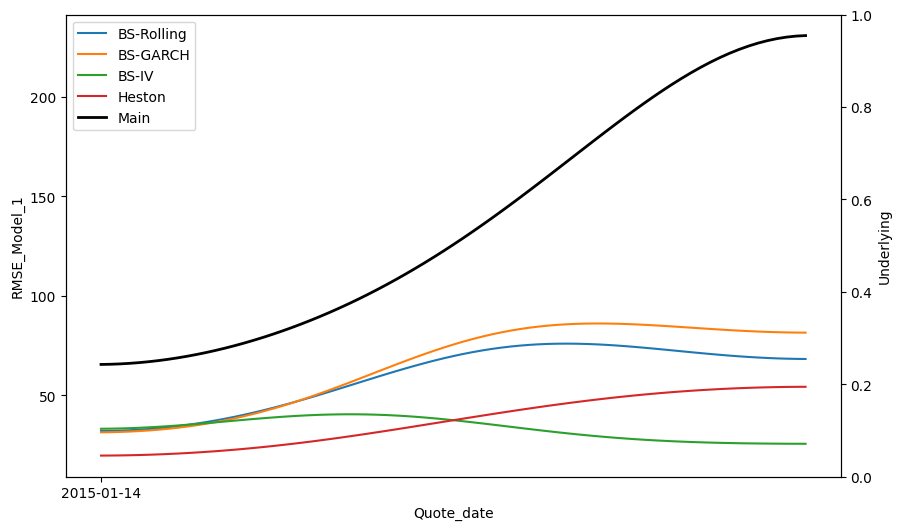

In [ ]:
# Group data by Quote_date and calculate RMSE for each group
rmse_df = df.groupby("Quote_date").apply(calculate_rmse).reset_index()


# Smooth the RMSE values by using gaussian filter
sigma = 15
rmse_df["RMSE_Model_1"] = gaussian_filter1d(rmse_df["RMSE_Model_1"], sigma=sigma)
rmse_df["RMSE_Model_2"] = gaussian_filter1d(rmse_df["RMSE_Model_2"], sigma=sigma)
rmse_df["RMSE_Model_3"] = gaussian_filter1d(rmse_df["RMSE_Model_3"], sigma=sigma)
rmse_df["RMSE_Model_4"] = gaussian_filter1d(rmse_df["RMSE_Model_4"], sigma=sigma)
rmse_df["RMSE_Model_5"] = gaussian_filter1d(rmse_df["RMSE_Model_5"], sigma=sigma)


# Plot the RMSE values for each model
fig, ax = plt.subplots(figsize=(10, 6))
sns.lineplot(data=rmse_df, x="Quote_date", y="RMSE_Model_1", label="BS-Rolling", ax=ax)
sns.lineplot(data=rmse_df, x="Quote_date", y="RMSE_Model_2", label="BS-GARCH", ax=ax)
sns.lineplot(data=rmse_df, x="Quote_date", y="RMSE_Model_3", label="BS-IV", ax=ax)
sns.lineplot(data=rmse_df, x="Quote_date", y="RMSE_Model_4", label="Heston", ax=ax)
sns.lineplot(data=rmse_df, x="Quote_date", y="RMSE_Model_5", label="Main", ax=ax, color="black", linewidth=2)


# Set the interval for x-axis labels
ax.xaxis.set_major_locator(ticker.MultipleLocator(base=base))
ax2 = ax.twinx()
ax2.set_ylabel("Underlying")

# Underlying
sns.lineplot(data=rmse_df, x="Quote_date", y="Underlying_last", label="Underlying_last", color="black", ax=ax2, linestyle="--")

# Set y limit between 0 and 100
#ax.set_ylim(0, 80)

plt.xlabel("Quote_date")
plt.ylabel("RMSE")
plt.title("RMSE for Models per day")
plt.legend()
plt.xticks(rotation=45)
plt.show()

# Diviation

KeyboardInterrupt: 

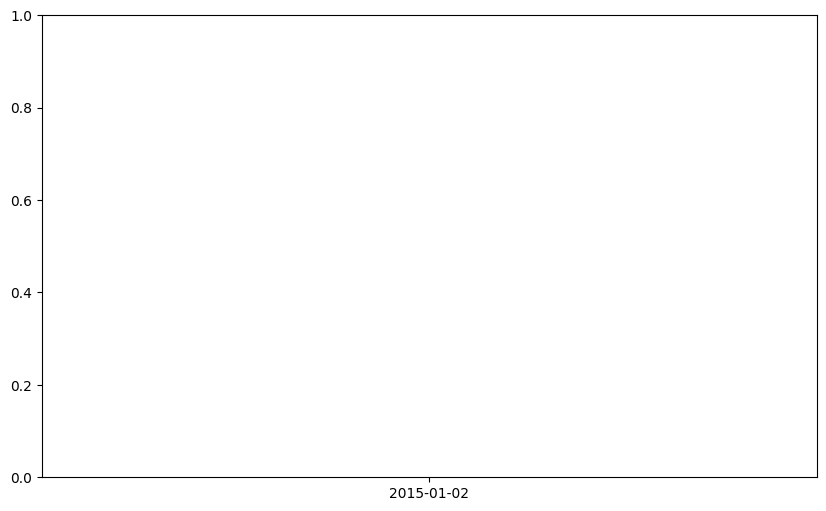

In [ ]:
for model in ["Rolling", "GARCH", "IV", "Heston", "Main"]:
    # New column with the difference between the prediction and the actual value
    df_temp = df.copy()
    df_temp["Diff"] = df["Price"] - df[model]

    fig, ax = plt.subplots(figsize=(5, 3))

    # Smooth the difference by using gaussian filter
    sigma = 15
    df_temp["Diff"] = gaussian_filter1d(df_temp["Diff"], sigma=sigma)

    # Plot the difference
    sns.lineplot(data=df_temp, x="Quote_date", y="Diff", ax=ax)

    # Set the interval for x-axis labels
    ax.xaxis.set_major_locator(ticker.MultipleLocator(base=base))
    plt.ylabel("Price - Model 3 Prediction")

    # Add zero line
    plt.axhline(y=0, color="red", linestyle="--", label="Actual Price")

    plt.xlabel("Quote_date")
    plt.ylabel("S&P 500 Price")
    plt.title("Deviation from market price")
    plt.xticks(rotation=30)
    plt.show()


### TTM

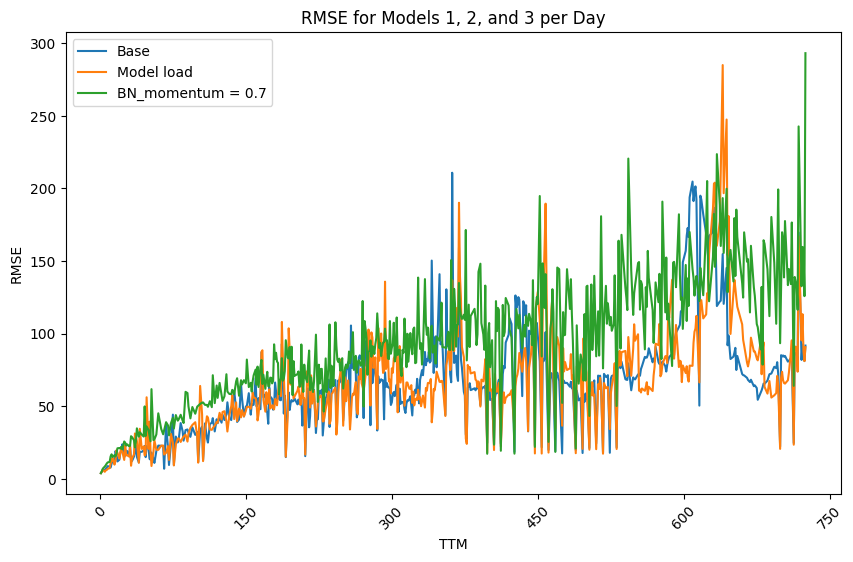

In [ ]:
# Group data by Quote_date and calculate RMSE for each group
rmse_df = df.groupby("TTM").apply(calculate_rmse).reset_index()


# Smooth the RMSE values by using gaussian filter
sigma = 15
rmse_df["RMSE_Model_1"] = gaussian_filter1d(rmse_df["RMSE_Model_1"], sigma=sigma)
rmse_df["RMSE_Model_2"] = gaussian_filter1d(rmse_df["RMSE_Model_2"], sigma=sigma)
rmse_df["RMSE_Model_3"] = gaussian_filter1d(rmse_df["RMSE_Model_3"], sigma=sigma)
rmse_df["RMSE_Model_4"] = gaussian_filter1d(rmse_df["RMSE_Model_4"], sigma=sigma)
rmse_df["RMSE_Model_5"] = gaussian_filter1d(rmse_df["RMSE_Model_5"], sigma=sigma)


# Plot the RMSE values for each model
fig, ax = plt.subplots(figsize=(10, 6))
sns.lineplot(data=rmse_df, x="TTM", y="RMSE_Model_1", label="BS-Rolling", ax=ax)
sns.lineplot(data=rmse_df, x="TTM", y="RMSE_Model_2", label="BS-GARCH", ax=ax)
sns.lineplot(data=rmse_df, x="TTM", y="RMSE_Model_3", label="BS-IV", ax=ax)
sns.lineplot(data=rmse_df, x="TTM", y="RMSE_Model_4", label="Heston", ax=ax)
sns.lineplot(data=rmse_df, x="TTM", y="RMSE_Model_5", label="Main", ax=ax, color="black", linewidth=2)

# Set the interval for x-axis labels
ax.xaxis.set_major_locator(ticker.MultipleLocator(base=0.25))


plt.xlabel("TTM")
plt.ylabel("RMSE")
plt.title("RMSE for the models at different TTM")
plt.legend()
plt.xticks(rotation=45)
plt.show()

### Moneyness

In [ ]:
# Add moneyness
df["Moneyness"] = df["Underlying_last"] / df["Strike"]

In [ ]:
# Group data by Moneyness and calculate RMSE for each group
rmse_df = df.groupby("Moneyness").apply(calculate_rmse).reset_index()


# Smooth the RMSE values by using gaussian filter
sigma = 15
rmse_df["RMSE_Model_1"] = gaussian_filter1d(rmse_df["RMSE_Model_1"], sigma=sigma)
rmse_df["RMSE_Model_2"] = gaussian_filter1d(rmse_df["RMSE_Model_2"], sigma=sigma)
rmse_df["RMSE_Model_3"] = gaussian_filter1d(rmse_df["RMSE_Model_3"], sigma=sigma)
rmse_df["RMSE_Model_4"] = gaussian_filter1d(rmse_df["RMSE_Model_4"], sigma=sigma)
rmse_df["RMSE_Model_5"] = gaussian_filter1d(rmse_df["RMSE_Model_5"], sigma=sigma)


# Plot the RMSE values for each model
fig, ax = plt.subplots(figsize=(10, 6))
sns.lineplot(data=rmse_df, x="Moneyness", y="RMSE_Model_1", label="BS-Rolling", ax=ax)
sns.lineplot(data=rmse_df, x="Moneyness", y="RMSE_Model_2", label="BS-GARCH", ax=ax)
sns.lineplot(data=rmse_df, x="Moneyness", y="RMSE_Model_3", label="BS-IV", ax=ax)
sns.lineplot(data=rmse_df, x="Moneyness", y="RMSE_Model_4", label="Heston", ax=ax)
sns.lineplot(data=rmse_df, x="Moneyness", y="RMSE_Model_5", label="Main", ax=ax, color="black", linewidth=2)

# Set the interval for x-axis labels
ax.xaxis.set_major_locator(ticker.MultipleLocator(base=0.1))

plt.ylim(0,15)

plt.xlabel("Moneyness")
plt.ylabel("Smoothed RMSE")
plt.title("Smoothed RMSE for Models 1, 2, and 3 per Day")
plt.legend()
plt.xticks(rotation=45)
plt.show()

KeyboardInterrupt: 

# Tabel

In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf

# Assuming df is a DataFrame with the required columns

df_low_money = df[df["Underlying_last"] / df["Strike"] < 0.97]
df_low_money.name = "<0.97"
df_mid_money = df[(df["Underlying_last"] / df["Strike"]).between(0.97, 1.03, inclusive=True)]
df_mid_money.name = "0.97-1.03"
df_high_money = df[df["Underlying_last"] / df["Strike"] > 1.03]
df_high_money.name = ">1.03"

df_table = pd.DataFrame(columns=['Moneyness', 'Maturity', 'Rolling', 'GARCH', 'IV', "Heston", "Main"])
maturity_intervals = [(0, 10), (10, 30), (30, 90), (90, 300), (300, 730)]

for dataframe in [df_low_money, df_mid_money, df_high_money]:
    for start, end in maturity_intervals:
        df_temp = dataframe[(dataframe["TTM"]).between(start, end, inclusive=True)]
        model_1 = np.sqrt(tf.keras.metrics.mean_squared_error(df_temp["Price"], df_temp["Rolling"]))
        model_2 = np.sqrt(tf.keras.metrics.mean_squared_error(df_temp["Price"], df_temp["GARCH"]))
        model_3 = np.sqrt(tf.keras.metrics.mean_squared_error(df_temp["Price"], df_temp["IV"]))
        model_4 = np.sqrt(tf.keras.metrics.mean_squared_error(df_temp["Price"], df_temp["Heston"]))
        model_5 = np.sqrt(tf.keras.metrics.mean_squared_error(df_temp["Price"], df_temp["Main"]))
        df_table.loc[len(df_table.index)] = [dataframe.name, f"{start}-{end}", model_1, model_2, model_3, model_4, model_5]




# Only provide the first moneyness column, not for the other maturities for that moneyness level
df_table["Moneyness"] = df_table["Moneyness"].where(df_table["Maturity"] == "0-10", "")


# Round the RMSE values to 2 decimal places
df_table = df_table.round(2)

# Bold the best RMSE value for each maturity and moneyness level by puttin \textbf{} around it
df_table["Rolling"] = df_table["Rolling"].apply(lambda x: "\\textbf{" + str(x) + "}" if x == df_table["Rolling"].min() else x)
df_table["GARCH"] = df_table["GARCH"].apply(lambda x: "\\textbf{" + str(x) + "}" if x == df_table["GARCH"].min() else x)
df_table["IV"] = df_table["IV"].apply(lambda x: "\\textbf{" + str(x) + "}" if x == df_table["IV"].min() else x)
df_table["Heston"] = df_table["Heston"].apply(lambda x: "\\textbf{" + str(x) + "}" if x == df_table["Heston"].min() else x)
df_table["Main"] = df_table["Main"].apply(lambda x: "\\textbf{" + str(x) + "}" if x == df_table["Main"].min() else x)

# Write to file
df_table.to_csv('RMSE_benchmark_tabel.csv', encoding='utf-8', index=False)

# Write to latex
with open('RMSE_benchmark_tabel.tex', 'w') as tf:
     tf.write(df_table.to_latex())


2023-05-02 09:16:13.209753: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


# Data analysis

### What's up with TTM = 4?

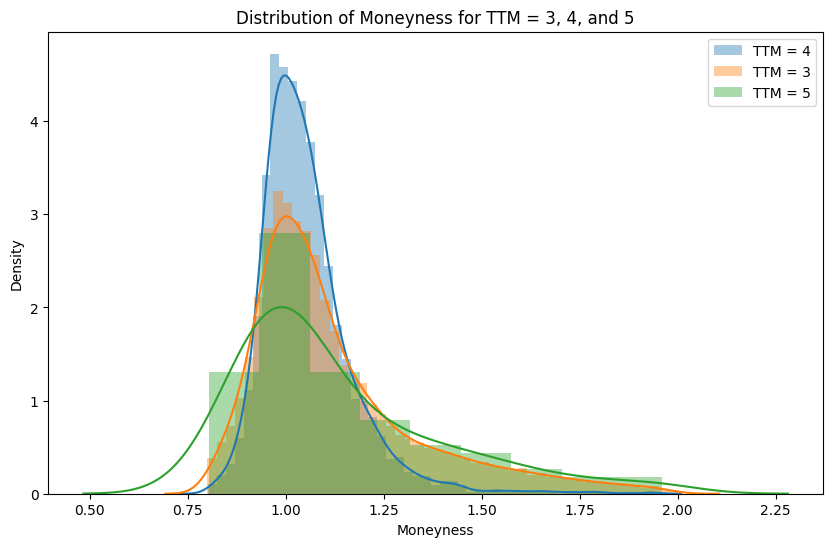

In [ ]:
# Plot distribution of moneyness of TTM = 4 vs TTM = 3 & TTM = 5 for just model 3
fig, ax = plt.subplots(figsize=(10, 6))

sns.distplot(df[df["TTM"] == 4]["Moneyness"], label="TTM = 4", ax=ax)
sns.distplot(df[df["TTM"] == 3]["Moneyness"], label="TTM = 3", ax=ax)
sns.distplot(df[df["TTM"] == 5]["Moneyness"], label="TTM = 5", ax=ax)


plt.xlabel("Moneyness")

plt.title("Distribution of Moneyness for TTM = 3, 4, and 5")
plt.legend()
plt.show()


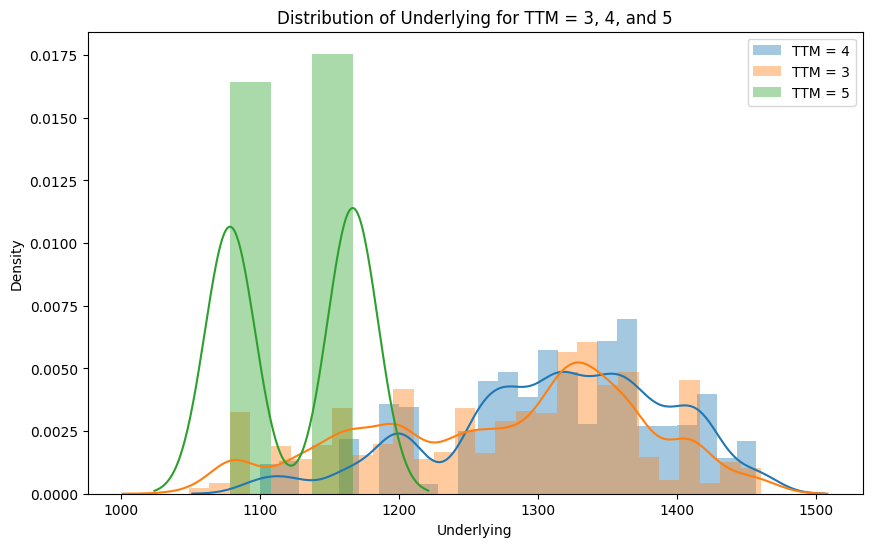

In [ ]:
# Plot distribution of underlying of TTM = 4 vs TTM = 3 & TTM = 5 for just model 3
fig, ax = plt.subplots(figsize=(10, 6))

sns.distplot(df[df["TTM"] == 4]["Underlying_last"], label="TTM = 4", ax=ax)

sns.distplot(df[df["TTM"] == 3]["Underlying_last"], label="TTM = 3", ax=ax)

sns.distplot(df[df["TTM"] == 5]["Underlying_last"], label="TTM = 5", ax=ax)


plt.xlabel("Underlying")

plt.title("Distribution of Underlying for TTM = 3, 4, and 5")
plt.legend()
plt.show()


In [ ]:
# Figure out what is different about the TTM = 4 data
print("TTM = 4")
display(df[df["TTM"] == 4].describe())

print("TTM = 4 or 5")
display(df[df["TTM"].isin([4, 5])].describe())


TTM = 4


,Unnamed: 0.1,Unnamed: 0,Price,Underlying_last,Strike,TTM,R,Moneyness,Volatility,Model 1,Model 2,Model 3,Diff
count,3325.000000,3325.000000,3325.000000,3325.000000,3325.000000,3325.0,3325.000000,3325.000000,3325.000000,3.325000e+03,3325.000000,3325.000000,3325.000000
mean,471999.322105,471999.322105,78.862902,1311.881368,1257.392481,4.0,0.053826,1.053560,0.174986,7.862264e+01,172.920372,291.063306,-212.200403
std,137764.318359,137764.318359,99.144476,81.691685,134.276141,0.0,0.048188,0.118349,0.083554,9.958464e+01,179.530271,328.371377,348.754608
min,207524.000000,207524.000000,0.020000,1099.650000,600.000000,4.0,0.000000,0.802103,0.077042,1.323274e-106,0.000000,0.000000,-1350.996600
25%,364443.000000,364443.000000,1.245000,1260.980000,1175.000000,4.0,0.020000,0.977716,0.115495,1.025701e+00,15.136392,28.761782,-354.087330
50%,464779.000000,464779.000000,43.395000,1316.090000,1265.000000,4.0,0.050000,1.032734,0.148399,4.201569e+01,108.175604,175.679230,-107.922300
75%,592835.000000,592835.000000,119.895000,1367.910000,1350.000000,4.0,0.070000,1.100876,0.224686,1.205914e+02,295.611281,436.235380,16.600000
max,697852.000000,697852.000000,657.000000,1457.090000,1800.000000,4.0,0.300000,1.938417,0.416952,6.570926e+02,685.700509,1369.002900,607.705000


TTM = 4 or 5


,Unnamed: 0.1,Unnamed: 0,Price,Underlying_last,Strike,TTM,R,Moneyness,Volatility,Model 1,Model 2,Model 3,Diff
count,3414.000000,3414.000000,3414.000000,3414.000000,3414.000000,3414.000000,3414.000000,3414.000000,3414.000000,3.414000e+03,3414.000000,3414.000000,3414.000000
mean,461585.827475,461585.827475,80.077289,1306.983301,1251.635911,4.026069,0.054534,1.055605,0.175140,7.984871e+01,174.639060,294.581717,-214.504428
std,150194.378198,150194.378198,101.440343,86.295257,140.799107,0.159364,0.047997,0.124778,0.083789,1.018708e+02,178.611645,331.743298,354.076106
min,44587.000000,44587.000000,0.020000,1078.340000,550.000000,4.000000,0.000000,0.802103,0.077042,1.323274e-106,0.000000,0.000000,-1350.996600
25%,359532.250000,359532.250000,1.196250,1257.800000,1170.000000,4.000000,0.020000,0.977014,0.110735,9.848131e-01,16.387961,28.940962,-358.716295
50%,454865.500000,454865.500000,43.247500,1315.890000,1265.000000,4.000000,0.050000,1.032750,0.148399,4.198480e+01,113.376400,179.865315,-108.861835
75%,592812.750000,592812.750000,120.925000,1367.910000,1345.000000,4.000000,0.070000,1.102248,0.224686,1.218236e+02,298.968147,436.971300,16.730277
max,697852.000000,697852.000000,657.000000,1457.090000,1800.000000,5.000000,0.300000,1.960618,0.416952,6.570926e+02,685.700509,1369.002900,607.705000


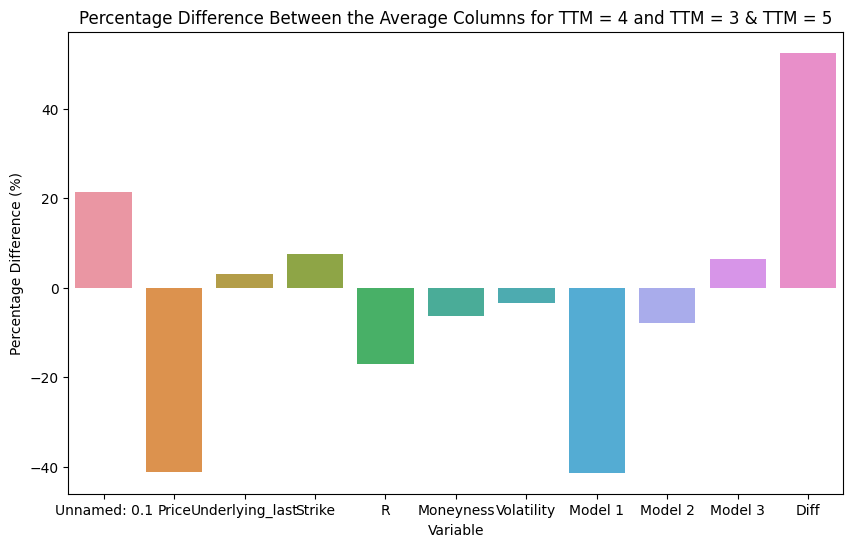

In [ ]:
# Calculate the mean values for each group
df_temp = df[df["TTM"].isin([3, 4, 5])].copy()
df_temp["TTM"] = df_temp["TTM"].replace({3: "3 or 5", 4: "4", 5: "3 or 5"})
df_temp = df_temp.groupby("TTM").mean().reset_index()

# Calculate the percentage difference between the mean values for each variable
mean_ttm_4 = df_temp[df_temp["TTM"] == "4"].drop(["TTM", "Unnamed: 0"], axis=1)
mean_ttm_3_5 = df_temp[df_temp["TTM"] == "3 or 5"].drop(["TTM", "Unnamed: 0"], axis=1)
percentage_diff = 100 * ((mean_ttm_4.values - mean_ttm_3_5.values) / mean_ttm_3_5.values)

# Create a new DataFrame with the percentage difference
percentage_diff_df = pd.DataFrame(percentage_diff, columns=mean_ttm_4.columns)
percentage_diff_df["TTM"] = "Percentage Difference"
percentage_diff_df = percentage_diff_df.melt(id_vars="TTM", var_name="Variable", value_name="Value")

# Plot the percentage difference using a bar plot
fig, ax = plt.subplots(figsize=(10, 6))
sns.barplot(data=percentage_diff_df, x="Variable", y="Value", ax=ax)

plt.xlabel("Variable")
plt.ylabel("Percentage Difference (%)")
plt.title("Percentage Difference Between the Average Columns for TTM = 4 and TTM = 3 & TTM = 5")
plt.show()
